## Mironov2019: Numerical computation of epsilon

In [17]:
import mpmath
import scipy
# from mpmath import mp, loggamma, log, exp

def compute_A_alpha(alpha, q, sigma):  # for now we have only support of integer alpha
    asum = 0
    for k in range(alpha + 1):
        asum += scipy.special.comb(alpha, k) * mpmath.power(1 - q, alpha - k) * mpmath.power(q, k) * mpmath.exp((k*k-k)/(2 * sigma * sigma))
    return asum

def compute_eps_precise(alpha, q, sigma): # this is Rényi epsilon for 1 step
    return float(1/(alpha - 1) * mpmath.log(compute_A_alpha(alpha, q, sigma)))

In [50]:
compute_eps_precise(7, 1/20000, 0.8)

3.3064530164748174e-08

In [35]:
import math
def find_max_eps_precise(alpha, T, epsilon, delta):
    return epsilon / T - math.log(1/delta)/((alpha - 1) * T)

In [52]:
find_max_eps_precise(7, 10000, 10, 1e-5)

0.0008081179089171629

In [37]:
def check_exp_parameters(alpha, q, sigma, T, epsilon, delta):
    try:
        return compute_eps_precise(alpha, q, sigma) < find_max_eps_precise(alpha, T, epsilon, delta)
    except OverflowError:
        print(f"Overflow on {alpha, q, sigma}")
        return False

In [20]:
from functools import lru_cache
import numpy as np

@lru_cache(maxsize=100)
def find_min_sigma(q, T, epsilon, delta, alpha_min=2, alpha_max=20, sigma_min=0.5, sigma_max=3):
    # Define your ranges for alpha and sigma
    alphas = np.arange(alpha_min, alpha_max, 1)          # Integer values for alpha
    sigmas = np.linspace(sigma_min, sigma_max, 30)   # Real values for sigma

    opt_sigma = 100000
    opt_alpha = None
    # Fill the lists based on your boolean condition
    for alpha in alphas:
        for sigma in sigmas:
            if check_exp_parameters(alpha, q, sigma, T, epsilon, delta):
                if sigma < opt_sigma:
                    opt_sigma = sigma
                    opt_alpha = alpha

    return opt_sigma


In [21]:
import matplotlib.pyplot as plt
def set_big_fonts_on_plot(additive=0):
    SMALL_SIZE = 14 + additive
    MEDIUM_SIZE = 16 + additive
    BIGGER_SIZE = 20 + additive
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    

def to_default_fonts_on_plot():
    plt.rcParams.update(plt.rcParamsDefault)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_valid_alpha_sigma(q, T, epsilon, delta,
                           alpha_min=2, alpha_max=20, sigma_min=0.5, sigma_max=3,
                           add_title=True, file_name='valid_sigma'):
    # Define your ranges for alpha and sigma
    alphas = np.arange(alpha_min, alpha_max, 1)          # Integer values for alpha
    sigmas = np.linspace(sigma_min, sigma_max, 30)   # Real values for sigma
    true_alphas, true_sigmas = [], []
    false_alphas, false_sigmas = [], []
    
    opt_sigma = 100000
    opt_alpha = None
    # Fill the lists based on your boolean condition
    for alpha in alphas:
        for sigma in sigmas:
            if check_exp_parameters(alpha, q, sigma, T, epsilon, delta):
                if sigma < opt_sigma or (sigma == opt_sigma and opt_alpha < alpha):
                    opt_sigma = sigma
                    opt_alpha = alpha
                true_alphas.append(alpha)
                true_sigmas.append(sigma)
            else:
                false_alphas.append(alpha)
                false_sigmas.append(sigma)
    print(f"Optimal sigma is {opt_sigma} for {opt_alpha=}")
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(true_alphas, true_sigmas, color='green', label='True', alpha=0.7)
    plt.scatter(false_alphas, false_sigmas, color='red', label='False', alpha=0.7)
    plt.scatter(opt_alpha, opt_sigma, color='purple', label='Optimal Point')

    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\sigma$')
    if add_title:
        plt.title(r'($\alpha$, $\sigma$) that guarantee ($\epsilon$, $\delta$)-dp of $T$ subsamplings')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig(f"../figs/{file_name}.pdf")
    plt.show()

In [76]:
from contextlib import contextmanager

@contextmanager
def temporary_globals(env):
    """Temporarily add variables to globals()"""
    old_env = {}
    try:
        # Save old values (if they exist)
        for k, v in env.items():
            if k in globals():
                old_env[k] = globals()[k]
            globals()[k] = v
        yield
    finally:
        # Restore old values
        for k in env:
            if k in old_env:
                globals()[k] = old_env[k]
            else:
                del globals()[k]


Optimal sigma is 0.49310344827586206 for opt_alpha=np.int64(7)


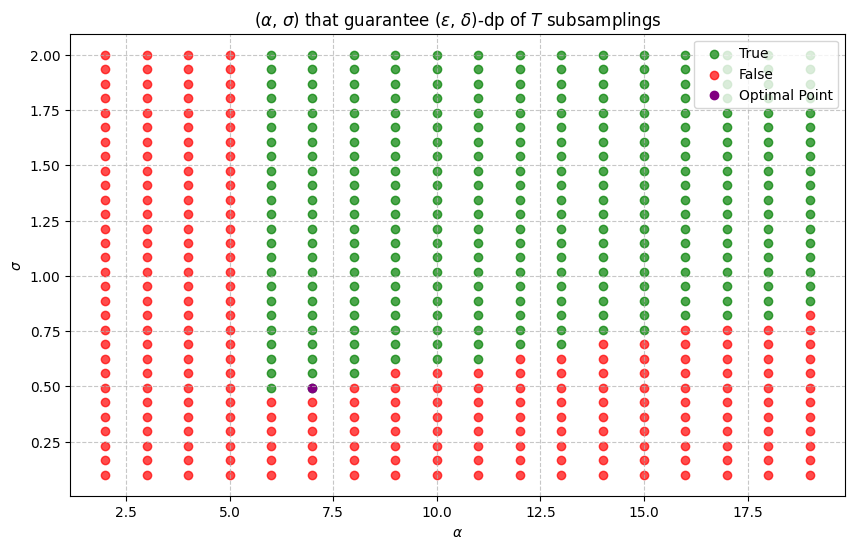

In [27]:
# Example
plot_valid_alpha_sigma(1/600000, 1000, 1.5, 1/600**1.1, sigma_min=0.1, sigma_max=2, add_title=True)

## Precise DP-accountant

In [53]:
import numpy as np
def topk(input_vec, k):
    """
    Top-k sparsifier: retains only the top-k entries (by absolute value) of vector v.
    
    Parameters:
    - v (np.ndarray): Input vector.
    - k (int): Number of top entries to keep.
    
    Returns:
    - np.ndarray: Sparsified vector with only top-k elements retained.
    """
    if k >= input_vec.size:
        return input_vec.copy()

    # Get indices of the top-k absolute values
    topk_indices = np.argpartition(np.abs(input_vec), -k)[-k:]

    # Create zero vector and fill in top-k entries
    sparse_v = np.zeros_like(input_vec)
    sparse_v[topk_indices] = input_vec[topk_indices]

    return sparse_v

In [54]:
topk(np.array([1, 2, 3, 4, 5]), 2)

array([0, 0, 0, 4, 5])

In [33]:
import numpy as np
from scipy.stats import norm

def dp_sign_by_sigma(g_t_m, sens_measure2, sigma):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2

    noise_to_privatize = np.random.normal(loc=0.0, scale=sigma * sens_measure2, size=g_t_m.shape)
    g_t_noised = g_t_m + noise_to_privatize
    return np.sign(g_t_noised)

In [34]:
import numpy as np
from scipy.stats import norm

def dp_by_sigma(g_t_m, sens_measure2, sigma):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2

    noise_to_privatize = np.random.normal(loc=0.0, scale=sigma * sens_measure2, size=g_t_m.shape)
    g_t_noised = g_t_m + noise_to_privatize
    return g_t_noised

In [100]:
import numpy as np
from scipy.stats import norm

def dp_sign_by_sigma_top_k(g_t_m, sens_measure2, sigma, k_percentage=0.1):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2
    noise_to_privatize = np.random.normal(loc=0.0, scale=sigma * sens_measure2, size=g_t_m.shape)
    g_t_noised = g_t_m
    g_t_noised += noise_to_privatize
    g_t_noised = topk(g_t_noised, round(k_percentage * g_t_noised.shape[0])) # correct order
    return np.sign(g_t_noised)

## Loading and Preparing data

Downloading Mushrooms dataset:

In [35]:
import requests
from sklearn.datasets import load_svmlight_file

# URL of the file to download
url = 'https://hse24.fmin.xyz/files/mushrooms.txt'

# Download the file and save it locally
response = requests.get(url)
dataset = 'mushrooms.txt'
dataset_path = '../data/'+dataset

# Ensure the request was successful
if response.status_code == 200:
    with open(dataset_path, 'wb') as f:
        f.write(response.content)

    # Load the dataset from the downloaded file
    data = load_svmlight_file(dataset_path)
    A, b = data[0].toarray(), data[1]
    n, d = A.shape
    b = (b - 3/2) * 2 # to +-1
    print("Data loaded successfully.")
    print(f"Number of samples: {n}, Number of features: {d}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Data loaded successfully.
Number of samples: 8124, Number of features: 112


Splitting data for 10 workers:

In [36]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
# Number of workers
num_workers = 10

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=214)

# Initialize empty lists for workers
X_splits, y_splits = [], []

X_remaining, y_remaining = A_train, b_train
for _ in range(num_workers - 1):  # Last worker gets remaining data
    X_part, X_remaining, y_part, y_remaining = train_test_split(
        X_remaining, y_remaining, train_size=1/(num_workers - len(X_splits)), stratify=y_remaining
    )
    X_splits.append(X_part)
    y_splits.append(y_part)

X_splits.append(X_remaining)  # Last split
y_splits.append(y_remaining)

# Workers' data
workers_data = list(zip(X_splits, y_splits))

workers_data[0][0].shape

(649, 112)

## Functions for Logistic Regression 

2 basic functions, loss and its gradient:

In [37]:
from jax import jit
import jax.numpy as jnp
@jit
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

In [38]:
def compute_gradient_regression(mat_A, vec_b, point_w, reg_const):
    m = mat_A.shape[0]
    sigmoid_vec = 1 / (1 + np.exp(vec_b * (mat_A @ point_w)))
    return (1/m) * mat_A.T @ (-vec_b * sigmoid_vec) + reg_const * point_w


To find an optimal solution:

In [39]:
import cvxpy as cp
def compute_optimal_regression(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

To test the model:

In [40]:
from jax import nn
@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: -1 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, -1, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy

In [41]:
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu, iter_log_step=1):
    f = lambda w: logistic_loss(w, X_train, y_train, mu)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
        "iter_log_step": iter_log_step
    }
    return metrics

## Algorithms

In [306]:
import numpy as np
from scipy.stats import levy_stable
import time


def regression_gradient_descent(w_init, workers_data, learning_rate, total_iteration_num, lambda_reg, momentum=0,
                                alg='gd', noise=None, send_time=1e-4, eps_privacy=10, delta_privacy_power=1.1,
                                step_of_logging=10):
    times = [0]
    start_time = time.time()

    trajectory = [w_init.copy()]
    w = w_init.copy()
    send_bit_counter = 0

    final_epsilon = eps_privacy
    final_power_in_delta = delta_privacy_power
    for iter in range(total_iteration_num):
        sum_grads = 0
        for mat_A, vec_b in workers_data: # checking different users
            if alg in {'dp_sign_sgd_precise', 'topk_dp_sign_sgd_precise', 'dp_sgd_precise',
                       'dp_sign_sgd_precise_momentum', 'topk_dp_sign_sgd_precise_momentum', 'dp_sgd_precise_momentum'}:
                q = 1 / mat_A.shape[0]  # Poisson probability for subsampling
                dp_sigma = find_min_sigma(q, total_iteration_num, final_epsilon, 1/(mat_A.shape[0])**final_power_in_delta, alpha_min=2, alpha_max=20, sigma_min=0.7, sigma_max=1.5)
                included = np.random.rand(mat_A.shape[0]) < q  # Poisson
                is_empty_subsample = False
                if not included.any():
                    is_empty_subsample = True
                    pure_grad = 0 # dummy
                else:
                    pure_grad = compute_gradient_regression(mat_A[included, :], vec_b[included], w, lambda_reg)
            else:
                pure_grad = compute_gradient_regression(mat_A, vec_b, w, lambda_reg)
            time_before_noise = time.time()
            noise_std = 0.25
            if noise == 'normal':
                noise_grad = np.random.normal(0, noise_std, w.shape)
            elif noise == 'levy':
                alpha = 1.6    # For κ = 1.5
                beta = 0
                loc = 0
                noise_grad = np.array(levy_stable.rvs(alpha, beta, loc=loc, scale=noise_std, size=w.shape))
            else:
                noise_grad = 0
            noise_lag = time.time() - time_before_noise # because the noise is synthetic, and is not a part of the algorithm
            start_time += noise_lag
            grad = pure_grad + noise_grad
            if alg=='gd' or alg == 'gd_momentum':
                sum_grads += grad
                send_bit_counter += 8 # because floats instead of bools
            if alg =='sign_sgd' or alg == 'sign_sgd_momentum':
                sum_grads += np.sign(grad)
                send_bit_counter += 1
            if alg == 'dp_sign_sgd_precise' or alg == 'dp_sign_sgd_precise_momentum':
                if not is_empty_subsample:
                    sum_grads += dp_sign_by_sigma(grad, 5, dp_sigma)
            if alg == 'dp_sgd_precise' or alg == 'dp_sgd_precise_momentum':
                if not is_empty_subsample:
                    sum_grads += dp_by_sigma(grad, 5, dp_sigma)
            if alg == 'topk_dp_sign_sgd_precise' or alg == 'topk_dp_sign_sgd_precise_momentum':
                if not is_empty_subsample:
                    sum_grads += dp_sign_by_sigma_top_k(grad, 5, dp_sigma)
            if alg == 'chinese_dp_cheat' or alg == 'chinese_dp_cheat_momentum':
                sigma_cheat = 1 / final_epsilon * np.sqrt(2 * np.log(1.25 / (1/(mat_A.shape[0])**final_power_in_delta)))
                sum_grads += dp_sign_by_sigma(grad, 5, sigma_cheat)


        # Add momentum only for algorithms with '_momentum' in their name
        if 'momentum_buffer' not in locals():
            momentum_buffer = np.zeros_like(w)
        if alg in {'gd', 'dp_sgd_precise'}:
            w = w - learning_rate(iter) * (sum_grads / len(workers_data))
        if alg in {'sign_sgd', 'dp_sign_sgd_precise', 'chinese_dp_cheat', 'topk_dp_sign_sgd_precise'}:
            w = w - learning_rate(iter) * np.sign(sum_grads)
        if '_momentum' in alg:
            if alg in {'gd_momentum', 'dp_sgd_precise_momentum'}:
                grad_update = sum_grads / len(workers_data)
                momentum_buffer = momentum * momentum_buffer + (1 - momentum) * grad_update
                w = w - learning_rate(iter) * momentum_buffer
            if alg in {'sign_sgd_momentum', 'dp_sign_sgd_precise_momentum', 'chinese_dp_cheat_momentum', 'topk_dp_sign_sgd_precise_momentum'}:
                grad_update = np.sign(sum_grads)
                momentum_buffer = momentum * momentum_buffer + (1 - momentum) * grad_update
                w = w - learning_rate(iter) * momentum_buffer

        if iter % step_of_logging == 0:
            trajectory.append(w.copy())        
            times.append(time.time() - start_time + send_bit_counter * send_time)

    return trajectory, times



## Functions that conduct experiment and present the results

### Tools for backups

In [43]:
import pickle
import os

def pickle_data(data, data_name, version_name):
    folder_path = f"../data/{version_name}"
    os.makedirs(folder_path, exist_ok=True)
    with open(f"{folder_path}/{data_name}_{version_name}.pkl", "wb") as f:
        pickle.dump(data, f)

def unpickle_data(data_name, version_name):
    folder_path = f"../data/{version_name}"
    with open(f"{folder_path}/{data_name}_{version_name}.pkl", "rb") as f:
        return pickle.load(f)


### Runner of experiments

In [305]:
import jax
def run_experiments(params):
    mu = params["mu"]
    methods = params["methods"]
    sending_time = params["sending_time"]

    results = {}

    X_train = A_train
    y_train = b_train
    X_test = A_test
    y_test = b_test
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features

    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, )) # sigma is 1
    # x_0 = np.ones(n_features) * 5
    x_star, f_star = compute_optimal_regression(X_train, y_train, mu)
    methods_dict = {
        "SGD": 'gd',
        "SignSGD": 'sign_sgd',
        "DP-sign-SGD": 'dp_sign_sgd_precise',
        "DP-SGD": 'dp_sgd_precise',
        "Chinese-DP-SignSGD-cheat": 'chinese_dp_cheat',
        "topk-DP-sign-SGD Precise": 'topk_dp_sign_sgd_precise',

        "SGD-momentum": 'gd_momentum',
        "SignSGD-momentum": 'sign_sgd_momentum',
        "DP-sign-SGD-momentum": 'dp_sign_sgd_precise_momentum',
        "DP-SGD-momentum": 'dp_sgd_precise_momentum',
        "Chinese-DP-SignSGD-cheat-momentum": 'chinese_dp_cheat_momentum',
        "topk-DP-sign-SGD Precise-momentum": 'topk_dp_sign_sgd_precise_momentum'
    }
    for method in methods:
        learning_rate = method["learning_rate"]
        iterations = method["iterations"]
        noise = method["noise_type"]
        epsilon = method.get("eps_privacy", None)
        delta_power = method.get("delta_privacy_power", 0)
        momentum = method.get("momentum", 0)
        trajectory, times = regression_gradient_descent(x_0, workers_data, learning_rate, iterations, mu, momentum=momentum,
                                                        alg=methods_dict[method["method"]], noise=noise, 
                                                        eps_privacy=epsilon,
                                                        delta_privacy_power=delta_power,
                                                        send_time=sending_time,
                                                        step_of_logging=10)
        label = method["description"] # f'{method["method"]} with {noise} noise' # with lr {round(learning_rate, 3)}' #  and 
        results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu, 10)
        
    return results, params
    

### Presenter of experiments

In [202]:
import os
import matplotlib.pyplot as plt
def plot_long_results(results, params, code_version, legend_place='bottom'):
    set_big_fonts_on_plot(additive=1)
    plt.figure(figsize=(16, 8))
    mu = params["mu"]
    sending_time = params["sending_time"]
    if mu > 1e-2:
        title_str = f"Strongly convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit."
    else:
        title_str = f"Convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit."

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        x_coords = range(0, len(metrics['f_gap']) * metrics['iter_log_step'], metrics['iter_log_step'])
        plt.plot(x_coords, metrics['f_gap'], alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        x_coords = range(0, len(metrics['x_gap']) * metrics['iter_log_step'], metrics['iter_log_step'])
        plt.plot(x_coords, metrics['x_gap'], label=method, alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        x_coords = range(0, len(metrics['train_acc']) * metrics['iter_log_step'], metrics['iter_log_step'])
        plt.plot(x_coords, metrics["train_acc"], alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        x_coords = range(0, len(metrics['test_acc']) * metrics['iter_log_step'], metrics['iter_log_step'])
        plt.plot(x_coords, metrics["test_acc"], alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'], alpha=0.7)
    plt.xlabel('Time, sec')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'], alpha=0.7)
    plt.xlabel('Time, sec')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"], alpha=0.7)
    plt.xlabel('Time, sec')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"], alpha=0.7)
    plt.xlabel('Time, sec')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    if legend_place == 'bottom':
        plt.figlegend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15), frameon=True, alignment='center')
    if legend_place == 'right':
        plt.figlegend(loc='center left', bbox_to_anchor=(1, 0.5))
    

    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}"
    folder_path = f"../figs/{code_version}/long/"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    os.makedirs(folder_path, exist_ok=True)
    filename = code_version
    plt.savefig(os.path.join(folder_path, filename + "_long.pdf"),bbox_inches='tight')
    with open(folder_path + filename + '_long.txt', 'w') as output:
        output.write(title_str)

    plt.show()
    to_default_fonts_on_plot()

In [212]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
def plot_short_results(results, params, code_version, legend_place='bottom', more_space_for_legend=False):
    set_big_fonts_on_plot(additive=1)
    # plt.figure(figsize=(16, 8))
    mu = params["mu"]
    sending_time = params["sending_time"]
    if mu > 1e-2:
        title_str = f"Strongly convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit"
    else:
        title_str = f"Convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit"

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    for ax in axs:
        formatter = ScalarFormatter(useMathText=True)  # useMathText=True makes nice 10^5 instead of 1e5
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))  # Use scientific notation for big/small numbers
    
        ax.xaxis.set_major_formatter(formatter)
        # Tell matplotlib to move the offset text (the ×10^5) to top-right
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(-3, 3))

    ax = axs[0]
    # plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        x_coords = range(0, len(metrics['f_gap']) * metrics['iter_log_step'], metrics['iter_log_step'])
        ax.plot(x_coords, metrics['f_gap'], alpha=0.7)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$|f(x) -f^*|$')
    ax.set_yscale('log')
    ax.grid(linestyle=":")

    ax = axs[1]
    # plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        x_coords = range(0, len(metrics['x_gap']) * metrics['iter_log_step'], metrics['iter_log_step'])
        ax.plot(x_coords, metrics['x_gap'], label=method, alpha=0.7)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('$\|x_k - x^*\|$')
    ax.set_yscale('log')
    ax.grid(linestyle=":")

    ax = axs[2]
    # plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        ax.plot(metrics["time"], metrics["test_acc"], alpha=0.7)
    ax.set_xlabel('Time, sec')
    ax.set_ylabel('Test accuracy')
    # plt.yscale('log')
    ax.grid(linestyle=":")
    # Place the legend below the plots
    if legend_place == 'bottom':
        plt.figlegend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15), frameon=True, alignment='center')
            
    if legend_place == 'right':
        plt.figlegend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}"
    filename = code_version
    folder_path = f"../figs/{code_version}/short/"
    if more_space_for_legend:
        plt.tight_layout(rect=[0, 0.15, 1, 1])
    else:
        plt.tight_layout(rect=[0, 0.05, 1, 1])
    os.makedirs(folder_path, exist_ok=True)
    plt.savefig(os.path.join(folder_path, filename + "_short.pdf"), bbox_inches='tight')
    with open(folder_path + filename + '_short.txt', 'w') as output:
        output.write(title_str)
    plt.show()
    to_default_fonts_on_plot()

## Comparing the algorithms

In [316]:
code_version = 'v29_momentum'

In [183]:
workers_data[9][0].shape[0]

650

Optimal sigma is 0.8620689655172413 for opt_alpha=9


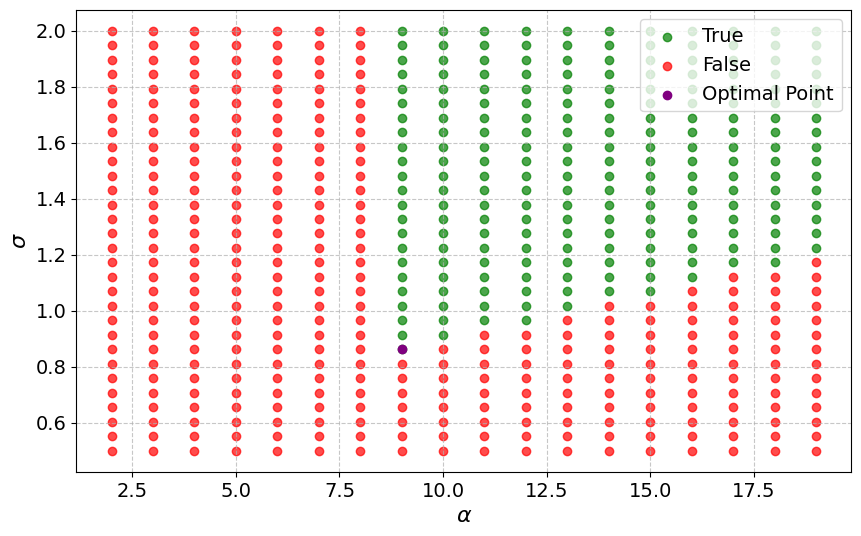

In [78]:
# Preparing grid search for presentation
with temporary_globals({'n': workers_data[0][0].shape[0]}):
    plot_valid_alpha_sigma(1/n, 1000, 1, 1/n**1.1, sigma_min=0.5, sigma_max=2, add_title=False,
                           file_name='grid_sigma_to_pres')

In [329]:
iterations = 1000
dpiterations = 100000
feature_num = A.shape[1]
dp_lr_const = lambda iter: 1/np.sqrt(feature_num)/10
dp_lr_dyn = lambda iter: 1/np.sqrt(feature_num)/10 / (iter+1)**(1/5)
basic_lr = dp_lr_const
params = {
    "mu": 1e-3,
    "sending_time": 0,
    "methods": [
        {
            "method": "SignSGD",
            "learning_rate": basic_lr,
            "iterations": iterations,
            "noise_type": "no",
            "description": "SignSGD no noise",
        },
        {
            "method": "SignSGD",
            "learning_rate": basic_lr,
            "iterations": iterations * 3,
            "noise_type": "levy",
            "description": "SignSGD Lévy noise",
        },

        {
            "method": "DP-sign-SGD-momentum",
            "learning_rate": dp_lr_dyn,
            "iterations": dpiterations,
            "momentum": 0.9,
            "noise_type": "levy",
            "eps_privacy": 10,
            "delta_privacy_power": 1.1,
            "description": r"$(10, n^{-1.1})$-DP-SignSGD momentum 0.9 lr = $\frac{1}{10 \sqrt{d} T^{1/5}}$ Lévy",
        },
        {
            "method": "DP-sign-SGD-momentum",
            "learning_rate": dp_lr_dyn,
            "iterations": dpiterations,
            "momentum": 0.6,
            "noise_type": "levy",
            "eps_privacy": 10,
            "delta_privacy_power": 1.1,
            "description": r"$(10, n^{-1.1})$-DP-SignSGD momentum 0.6 lr = $\frac{1}{10 \sqrt{d} T^{1/5}}$ Lévy",
        },
        {
            "method": "DP-sign-SGD",
            "learning_rate": dp_lr_dyn,
            "iterations": dpiterations,
            "noise_type": "levy",
            "eps_privacy": 10,
            "delta_privacy_power": 1.1,
            "description": r"$(10, n^{-1.1})$-DP-SignSGD no noise dyn lr = $\frac{1}{10 \sqrt{d} T^{1/5}}$ Lévy",
        },
        
    ]
}

results, params = run_experiments(params)

In [267]:
pickle_data(results, 'results', code_version)
pickle_data(params, 'params', code_version)

PicklingError: Can't pickle <function <lambda> at 0x000002879FCC4700>: attribute lookup <lambda> on __main__ failed

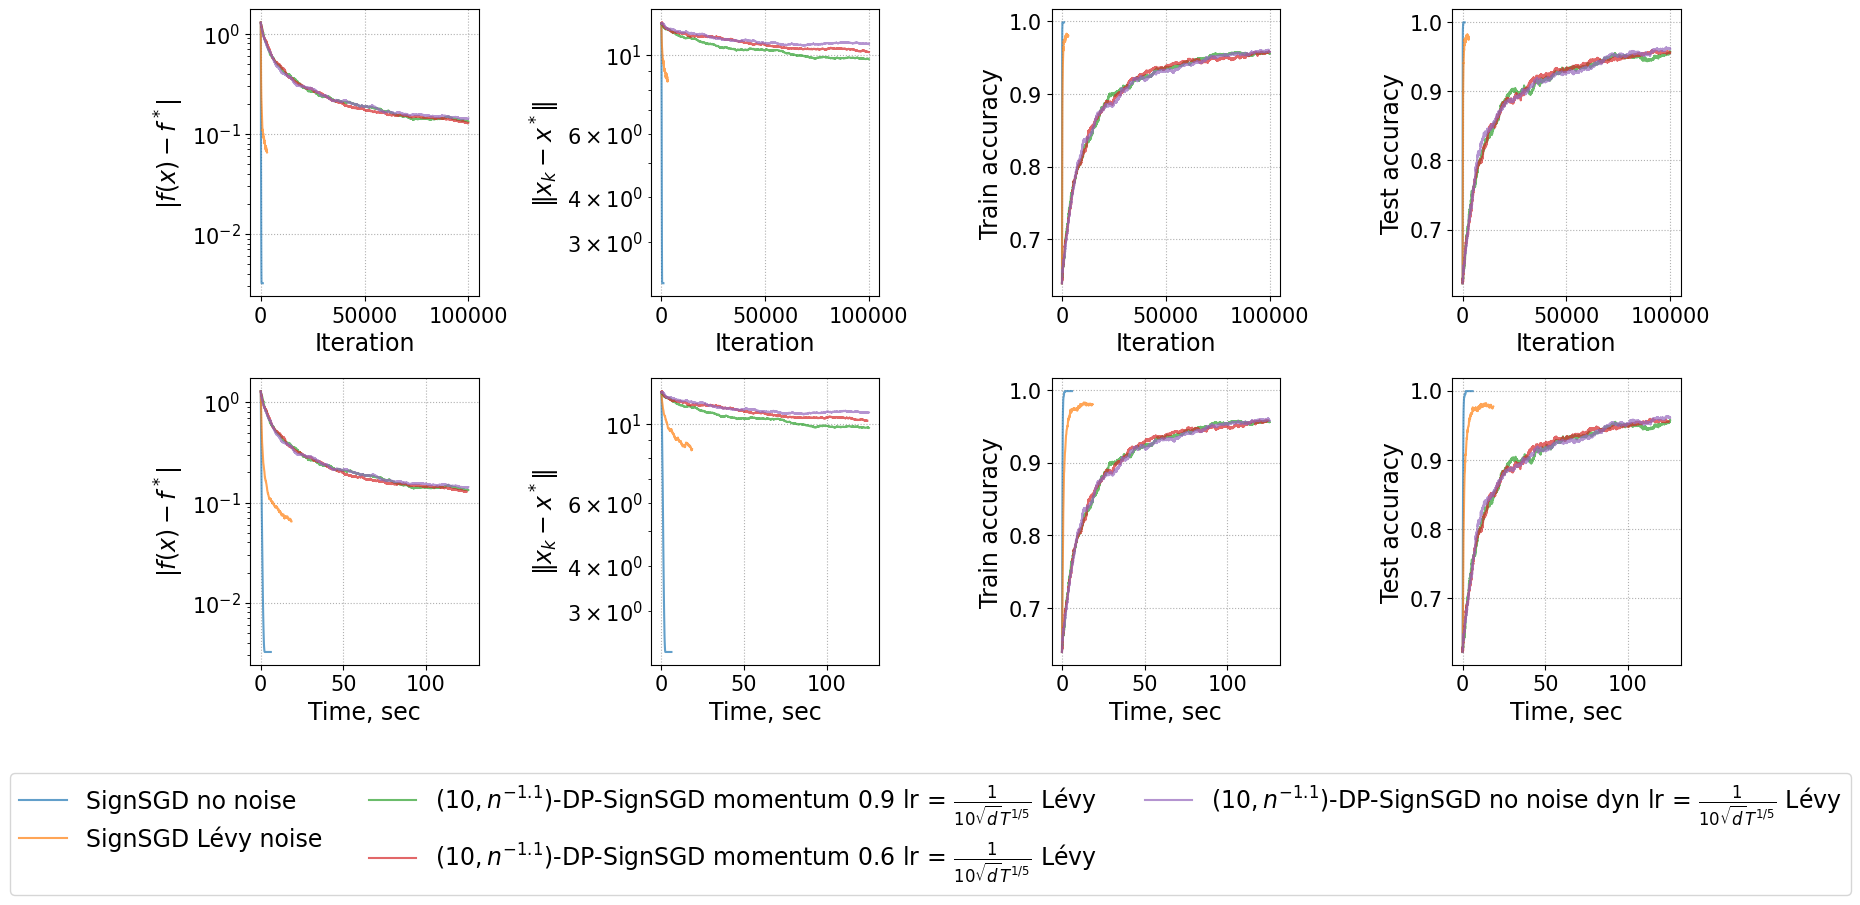

In [330]:
plot_long_results(results, params, code_version)

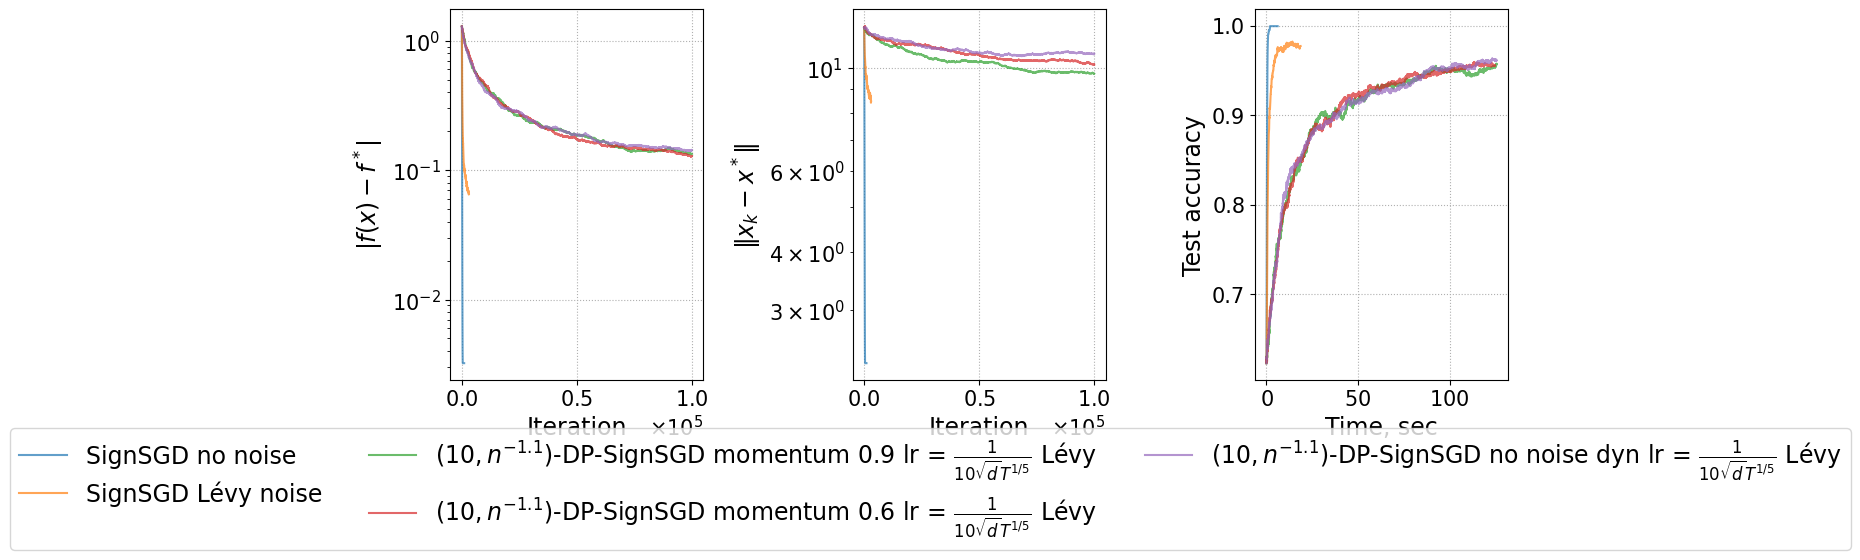

In [332]:
plot_short_results(results, params, code_version, more_space_for_legend=False)

In [80]:
results100K = unpickle_data('results', 'v17_10_workers')
params100K = unpickle_data('params', 'v17_10_workers')

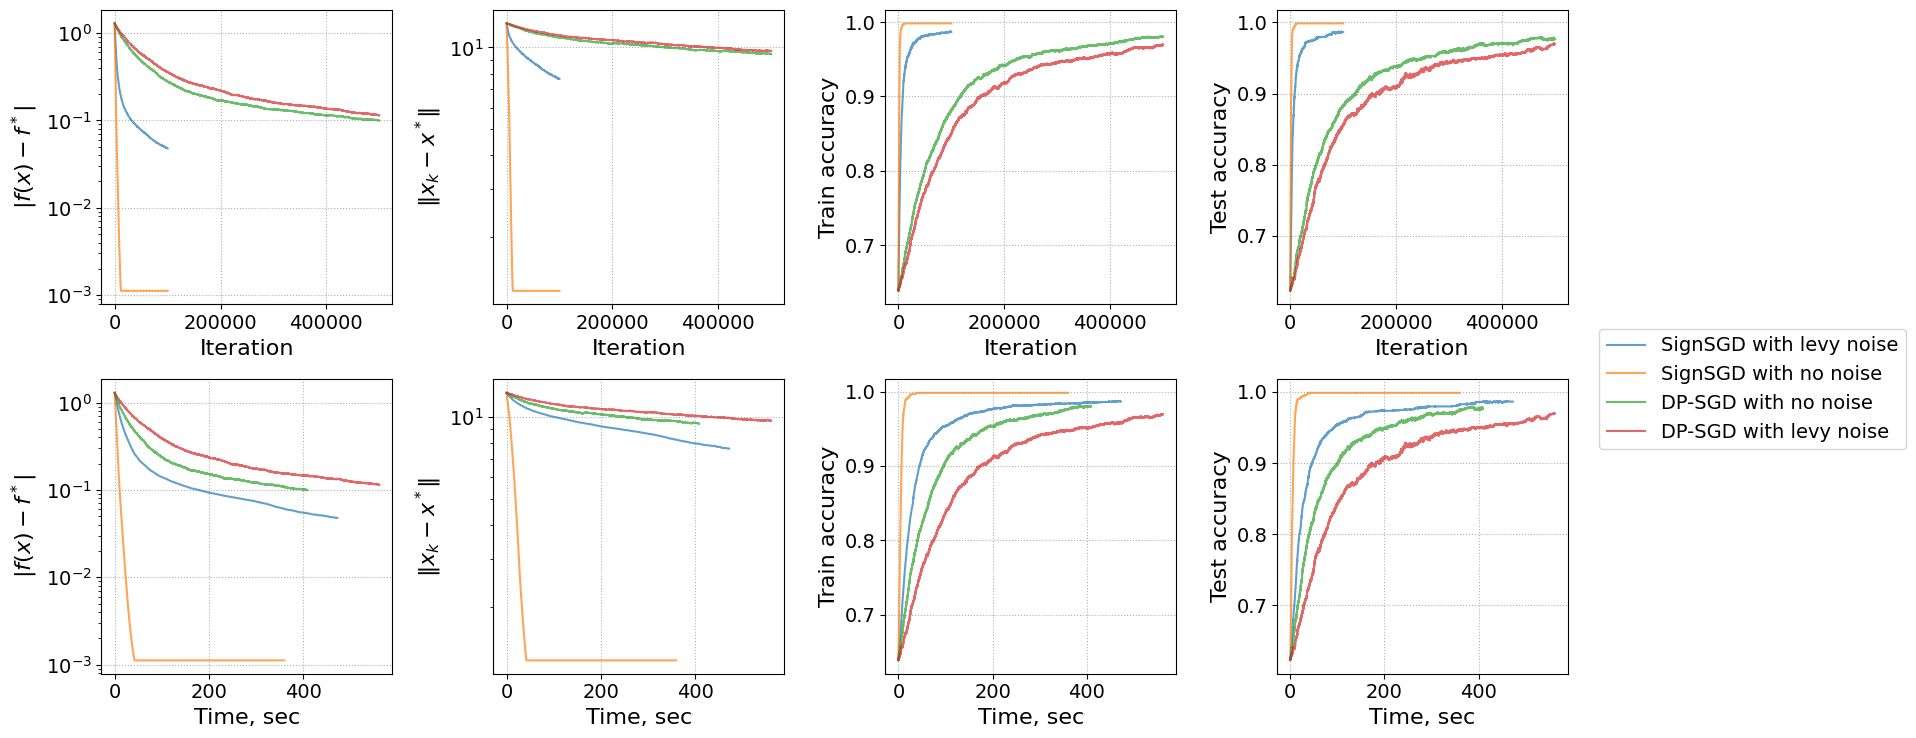

In [109]:
plot_long_results(results100K, params100K, 'v17_10_workers')

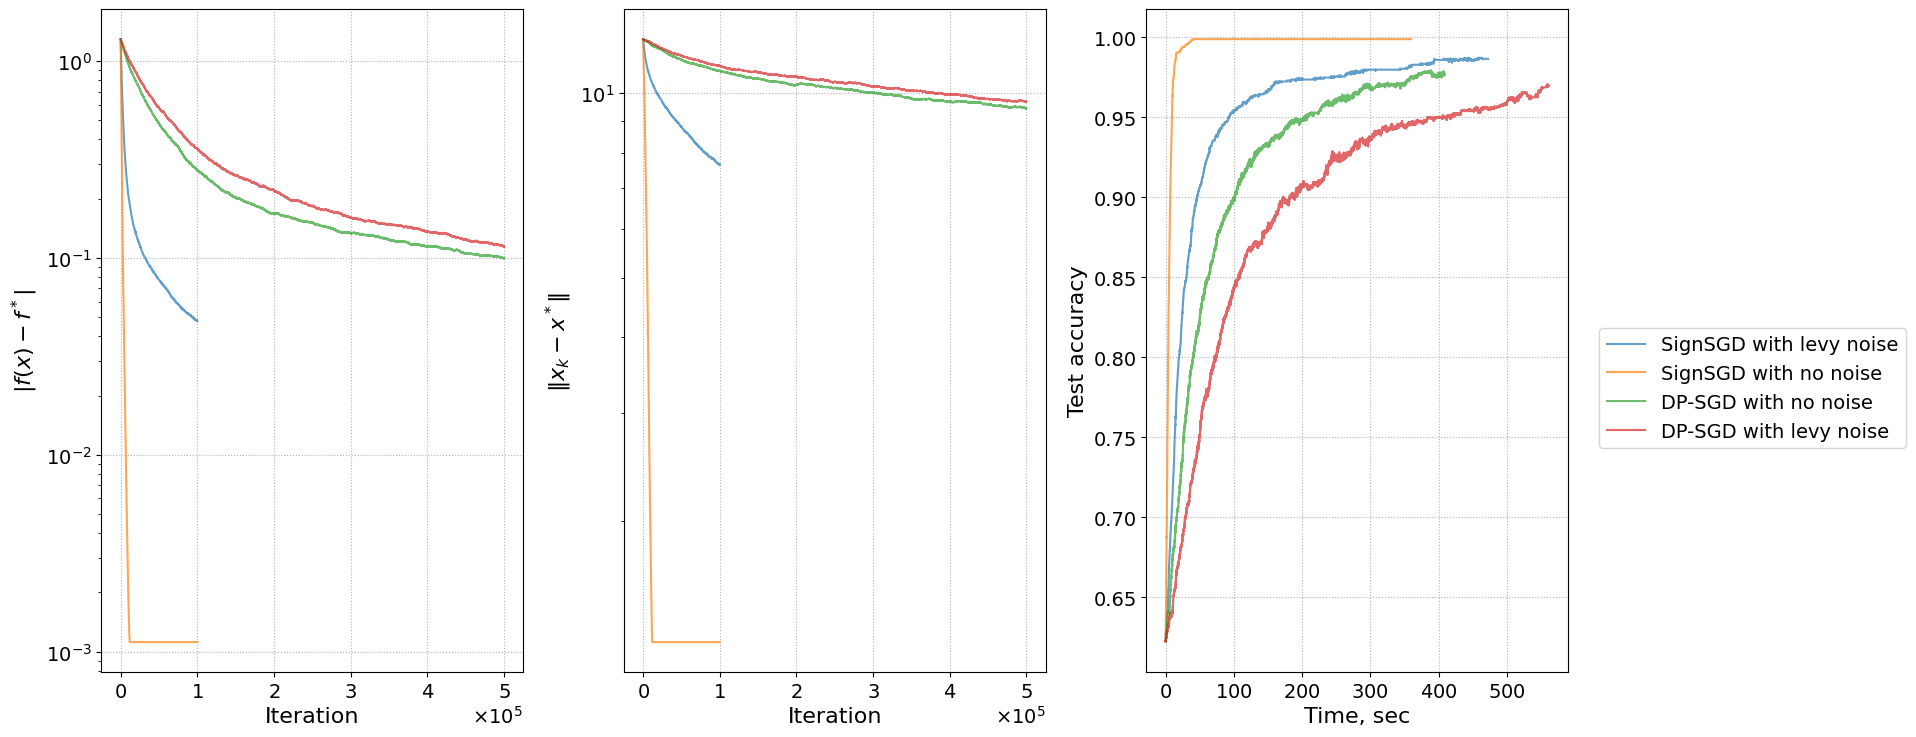

In [116]:
plot_short_results(results100K, params100K, 'v17_10_workers')

Future work:
* Optimizer for pytorch
* Momentum
* Simple neural network. MLP / or ResNet18 on CIFAR-10.
